Импортируем библиотеки

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

Подключаемся к гугл-диску

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Обработка датасета

Импортируем датасет

In [93]:
df = pd.read_csv('/content/drive/MyDrive/АД и МО/Spaceship_Titanic/train.csv')
print(df.shape)
df.head()

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [94]:
colum = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
for col in colum:
  print(f"{col}: {df[col].unique()}")

HomePlanet: ['Europa' 'Earth' 'Mars' nan]
CryoSleep: [False True nan]
Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
VIP: [False True nan]


In [95]:
colum = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
encoder = LabelEncoder()
for col in colum:
  df[col] = encoder.fit_transform(df[col])
  print(f"{col}: {df[col].unique()}")
df.head()

HomePlanet: [1 0 2 3]
CryoSleep: [0 1 2]
Destination: [2 1 0 3]
VIP: [0 1 2]


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,1,0,B/0/P,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,0,0,F/0/S,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,1,0,A/0/S,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,1,0,A/0/S,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,0,0,F/1/S,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Проверим количество уникальных значений для всех переменных с типом данных 'object' (категориальные переменные)

In [63]:
df.select_dtypes(include='object').nunique()

PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
dtype: int64

Удаляем категориальные переменные с большим количеством значений

In [86]:
df.drop(columns=['PassengerId', 'Cabin', 'Name'], inplace=True)
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,False
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,True
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,True


Проверим количество уникальных значений для всех переменных с типом данных 'float64' (числовые переменные)

In [65]:
df.select_dtypes(include='float64').nunique()

Age               80
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
dtype: int64

Посмотрим процентное соотношение пустых переменных к общему количесву

In [66]:
df.isnull().sum() * 100 / df.shape[0]

HomePlanet      2.312205
CryoSleep       2.496261
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Transported     0.000000
dtype: float64

Пустые числовые переменные заполним средними значениями по столбцу

In [67]:
df['Age'].fillna(df['Age'].mean(), inplace = True)
df['RoomService'].fillna(df['RoomService'].mean(), inplace = True)
df['FoodCourt'].fillna(df['FoodCourt'].mean(), inplace = True)
df['ShoppingMall'].fillna(df['ShoppingMall'].mean(), inplace = True)
df['Spa'].fillna(df['Spa'].mean(), inplace = True)
df['VRDeck'].fillna(df['VRDeck'].mean(), inplace = True)

Пустые категориальные переменные удалим

In [68]:
df.dropna(inplace=True)
df.isnull().sum() * 100 / df.shape[0]

HomePlanet      0.0
CryoSleep       0.0
Destination     0.0
Age             0.0
VIP             0.0
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
Transported     0.0
dtype: float64

Превратим категориальные переменные в числовые

In [69]:
colum = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
encoder = LabelEncoder()
for col in colum:
  df[col] = encoder.fit_transform(df[col])
  print(f"{col}: {df[col].unique()}")
df.head()

HomePlanet: [1 0 2]
CryoSleep: [0 1]
Destination: [2 1 0]
VIP: [0 1]


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,False
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,True
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,True


С целью найти корреляции сделаем тепловую карту

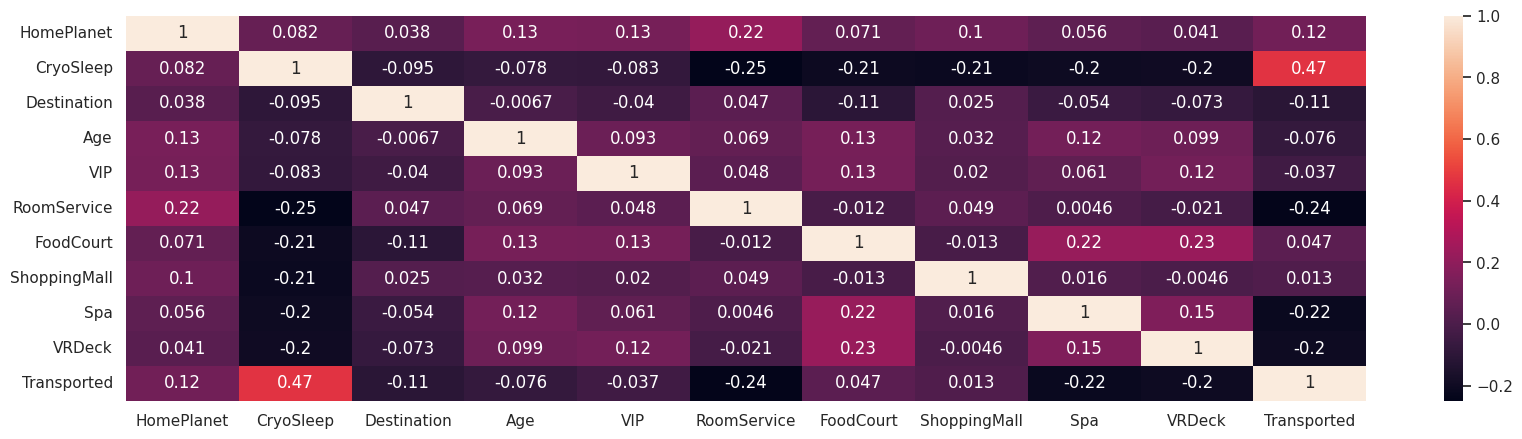

In [70]:
sns.set(rc={'figure.figsize':(20,5)})
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.show()

Корреляций нет, записываем "чистый" DataSet на гугл-диск

In [71]:
df.to_csv('/content/drive/MyDrive/АД и МО/Spaceship_Titanic/train_clean.csv', index=False)

# Поиск алгоритма для модели МО

Импортируем "чистый" DataSet




In [72]:
df = pd.read_csv('/content/drive/MyDrive/АД и МО/Spaceship_Titanic/train_clean.csv')
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,False
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,True
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,True


Создаём переменные с целевой колонкой и колонками для обучения

In [73]:
columns_train = df.columns[:-1:]
columns_target = df.columns[-1]

Создаём переменные с данными этих колонок

In [74]:
Y = df[columns_target]
X = df[columns_train]

Разделяем выборку на обучающую и тестовую

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

Проверяем размеры выборок

In [76]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(6330, 10) (6330,)
(1583, 10) (1583,)


Пробуем основные алгоритмы (считаем метрику "accuracy_score")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-77-0a18ce223109>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
<ipython-input-77-0a18ce223109>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
<ipython-input-77-0a18ce223109>:30: FutureWarning: The frame.append method is deprecated an

<Axes: title={'center': 'Classifier Accuracy'}, xlabel='Accuracy', ylabel='Classifier'>

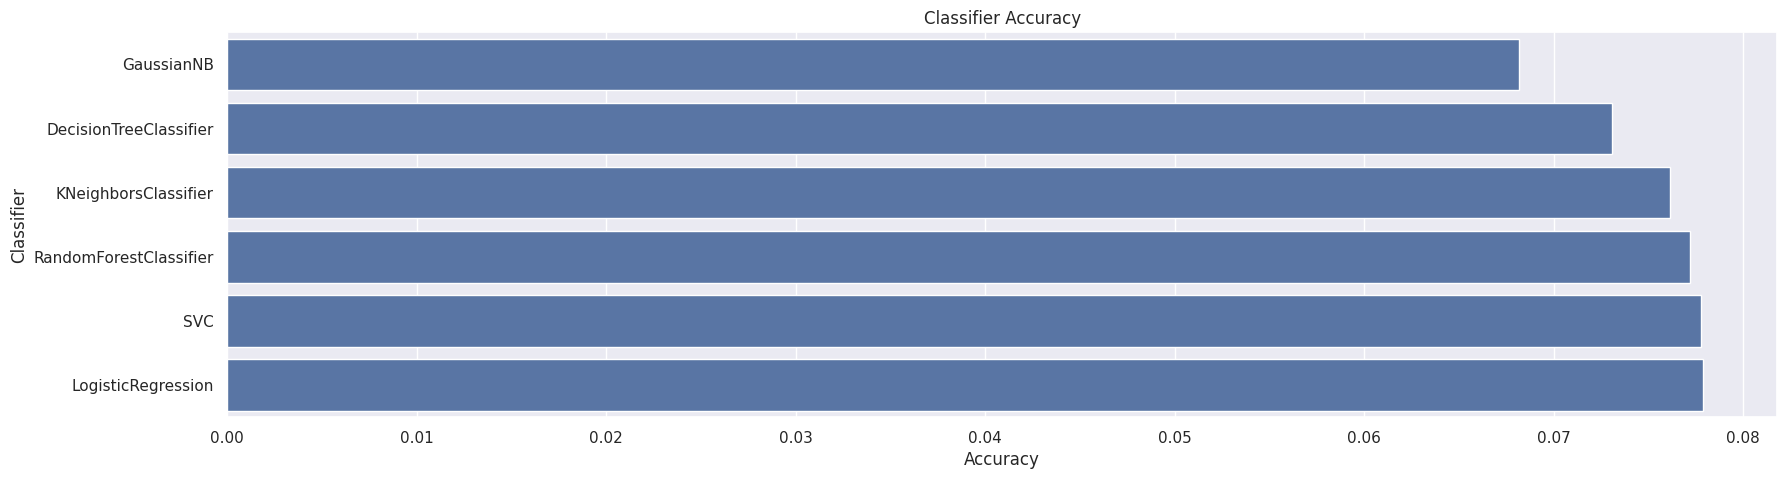

In [77]:
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    LogisticRegression(),
]

log = pd.DataFrame(columns=["Classifier", "Accuracy"])

acc_dict = {}

for clf in classifiers:

	name = clf.__class__.__name__
	clf.fit(X_train, Y_train)
	train_predictions = clf.predict(X_test)

	acc = accuracy_score(Y_test, train_predictions)

	if name in acc_dict:
		acc_dict[name] += acc
	else:
		acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=["Classifier", "Accuracy"])
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')
sns.barplot(x='Accuracy', y='Classifier', data=log.sort_values(by='Accuracy'), color="b")

Лучше всего себя показали SVC, RandomForestClassifier и LogisticRegression

Проверим те же алгоритмы, но посчитаем другую метрику (считаем метрику "f1_score")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-78-78df86112064>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
<ipython-input-78-78df86112064>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
<ipython-input-78-78df86112064>:30: FutureWarning: The frame.append method is deprecated an

<Axes: title={'center': 'Classifier f1'}, xlabel='f1', ylabel='Classifier'>

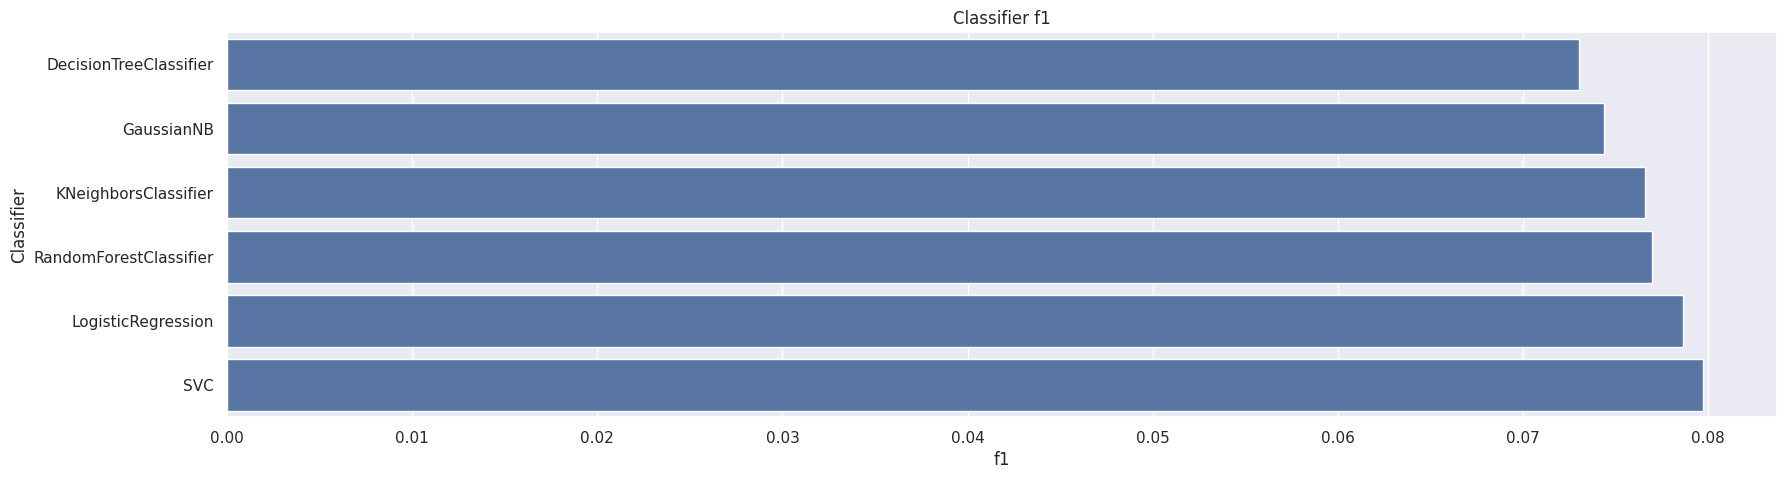

In [78]:
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    LogisticRegression(),
]

log = pd.DataFrame(columns=["Classifier", "f1"])

f1_dict = {}

for clf in classifiers:

	name = clf.__class__.__name__
	clf.fit(X_train, Y_train)
	train_predictions = clf.predict(X_test)

	f1 = f1_score(Y_test, train_predictions)

	if name in f1_dict:
		f1_dict[name] += f1
	else:
		f1_dict[name] = f1

for clf in f1_dict:
	f1_dict[clf] = f1_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, f1_dict[clf]]], columns=["Classifier", "f1"])
	log = log.append(log_entry)

plt.xlabel('f1')
plt.title('Classifier f1')
sns.barplot(x='f1', y='Classifier', data=log.sort_values(by='f1'), color="b")

Если на метрике "accuracy_score" SVC и LogisticRegression оказались на одном уровне, то на "f1_score" алгоритм SVC показал себя лучше, его и выберем

# Поиск наилучших параметров

In [79]:
'''
model = SVC()
param_grid = {
    'C':[0.1,1,100,1000],
    'kernel':['rbf','poly','sigmoid','linear'],
    'degree':[1,2,3,4,5,6],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}

grid = GridSearchCV(model, param_grid, cv = 5)
grid.fit(X_train, Y_train)
'''

"\nmodel = SVC()\nparam_grid = { \n    'C':[0.1,1,100,1000],\n    'kernel':['rbf','poly','sigmoid','linear'],\n    'degree':[1,2,3,4,5,6],\n    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]\n}\n\ngrid = GridSearchCV(model, param_grid, cv = 5)\ngrid.fit(X_train, Y_train)\n"

SVC алгоритм медленный, блок кода с подбором параметров выполнялся более 40 минут, после чего я прервал его выполнение, это чудовищно долго

Поэтому я решил взять второй по точности алгоритм - LogisticRegression

In [80]:
model = LogisticRegression()
param_grid = {
    'C' : np.logspace(-3,3,20),
    'penalty' : ['l2']
}
grid = GridSearchCV(model, param_grid, cv = 5)
grid.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                         'penalty': ['l2']})

In [81]:
print("Best parameters ", grid.best_params_)
print("Accuracy: ", grid.best_score_ * 100)

Best parameters  {'C': 0.008858667904100823, 'penalty': 'l2'}
Accuracy:  79.00473933649289


# Создание конечной модели

In [82]:
model = LogisticRegression(C = 0.008858667904100823)
model.fit(X_train, Y_train)
train_predictions = model.predict(X_test)
print('Accuracy: ', accuracy_score(Y_test, train_predictions))
print('F1: ', f1_score(Y_test, train_predictions))

Accuracy:  0.7782691092861656
F1:  0.7914438502673797


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
